In [92]:
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, PolynomialFeatures, RobustScaler, Normalizer
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.pipeline import Pipeline
import warnings
warnings.filterwarnings('ignore')

### Load data

In [93]:
train = pd.read_csv('train.csv').drop(['id', 'Row#'], axis = 1)
test = pd.read_csv('test.csv').drop(['id', 'Row#'], axis = 1)
train.columns

Index(['clonesize', 'honeybee', 'bumbles', 'andrena', 'osmia',
       'MaxOfUpperTRange', 'MinOfUpperTRange', 'AverageOfUpperTRange',
       'MaxOfLowerTRange', 'MinOfLowerTRange', 'AverageOfLowerTRange',
       'RainingDays', 'AverageRainingDays', 'fruitset', 'fruitmass', 'seeds',
       'yield'],
      dtype='object')

### Description of features

| **Original Column Name**  | **New Name**              | **Description**                                                                                                                                  |
|---------------------------|---------------------------|--------------------------------------------------------------------------------------------------------------------------------------------------|
| **Row#**                  | **ID**                    | A unique identifier for each row in the dataset, used for indexing purposes.                                                                     |
| **clonesize**             | **Clone Size**            | The size of the plant clone or group of genetically identical plants. This may affect crop yield.                                                 |
| **honeybee**              | **Honeybee Activity**     | The activity level or count of honeybees in the field, which are important for pollination.                                                       |
| **bumbles**               | **Bumblebee Activity**    | The activity level or count of bumblebees, which influence plant pollination and fruit development.                                               |
| **andrena**               | **Andrena Bee Activity**  | The activity level or count of Andrena bees, solitary pollinators that contribute to plant pollination.                                           |
| **osmia**                 | **Osmia Bee Activity**    | The activity level or count of Osmia bees, another type of solitary pollinator.                                                                  |
| **MaxOfUpperTRange**      | **Max Upper Temperature** | The maximum temperature in the upper temperature range. This can affect plant growth and pollinator activity.                                     |
| **MinOfUpperTRange**      | **Min Upper Temperature** | The minimum temperature in the upper temperature range, which may influence pollinator behavior and crop health.                                  |
| **AverageOfUpperTRange**  | **Avg Upper Temperature** | The average temperature in the upper temperature range, indicating typical conditions for pollination and plant growth.                           |
| **MaxOfLowerTRange**      | **Max Lower Temperature** | The maximum temperature in the lower temperature range, impacting plant and pollinator health during cooler periods.                              |
| **MinOfLowerTRange**      | **Min Lower Temperature** | The minimum temperature in the lower temperature range, which may indicate frost risk and affect plant health or pollinator activity.             |
| **AverageOfLowerTRange**  | **Avg Lower Temperature** | The average temperature in the lower temperature range, affecting plant and pollinator activity.                                                  |
| **RainingDays**           | **Rainy Days**            | The total number of rainy days, which can influence pollinator activity and crop yield.                                                           |
| **AverageRainingDays**    | **Avg Rainy Days**        | The average number of rainy days over a period, impacting overall pollination and plant health.                                                   |
| **fruitset**              | **Fruit Set**             | The percentage or count of flowers that successfully turn into fruit, indicating the effectiveness of pollination.                                |
| **fruitmass**             | **Fruit Mass**            | The average mass of individual fruits, which can directly impact the total yield.                                                                 |
| **seeds**                 | **Seed Count**            | The number of seeds per fruit or total seed count, which may reflect the success of pollination and fertilization.                                |
| **yield**                 | **Yield** (Target)        | The total agricultural production or output, typically measured in weight or volume per unit area.                                                |


### Changing feature names into some better ones

In [94]:
import pandas as pd

def change_columns(data):
    data = data.rename(columns={
        # 'Row#': 'ID',
        'clonesize': 'Clone Size',
        'honeybee': 'Honeybee Activity',
        'bumbles': 'Bumblebee Activity',
        'andrena': 'Andrena Bee Activity',
        'osmia': 'Osmia Bee Activity',
        'MaxOfUpperTRange': 'Max Upper Temperature',
        'MinOfUpperTRange': 'Min Upper Temperature',
        'AverageOfUpperTRange': 'Avg Upper Temperature',
        'MaxOfLowerTRange': 'Max Lower Temperature',
        'MinOfLowerTRange': 'Min Lower Temperature',
        'AverageOfLowerTRange': 'Avg Lower Temperature',
        'RainingDays': 'Rainy Days',
        'AverageRainingDays': 'Avg Rainy Days',
        'fruitset': 'Fruit Set',
        'fruitmass': 'Fruit Mass',
        'seeds': 'Seed Count',
        'yield': 'Yield'
    })

    return data

test = change_columns(test)
train = change_columns(train)
train.head()


,Clone Size,Honeybee Activity,Bumblebee Activity,Andrena Bee Activity,Osmia Bee Activity,Max Upper Temperature,Min Upper Temperature,Avg Upper Temperature,Max Lower Temperature,Min Lower Temperature,Avg Lower Temperature,Rainy Days,Avg Rainy Days,Fruit Set,Fruit Mass,Seed Count,Yield
0,12.5,0.25,0.25,0.25,0.75,69.7,42.1,58.2,50.2,24.3,41.2,16.00,0.26,0.477941,0.423927,34.043022,6079.08526
1,25.0,0.00,0.00,0.00,0.00,86.0,52.0,71.9,62.0,30.0,50.8,3.77,0.06,0.334594,0.354415,27.735098,2946.92602
2,25.0,0.50,0.25,0.75,0.63,86.0,52.0,71.9,62.0,30.0,50.8,34.00,0.56,0.468192,0.417915,34.838815,5323.30034
3,25.0,0.50,0.25,0.38,0.75,69.7,42.1,58.2,50.2,24.3,41.2,24.00,0.39,0.500558,0.427431,35.134955,6157.05484
4,12.5,0.25,0.38,0.50,0.75,77.4,46.8,64.7,55.8,27.0,45.8,24.00,0.39,0.520181,0.464067,37.029180,6992.82314


In [95]:
def FE(df): 
    # Renaming columns to match the new names
    df["Total Bee Density"] = df['Honeybee Activity'] + df['Bumblebee Activity'] + df['Andrena Bee Activity'] + df['Osmia Bee Activity']
    df["Bee to Clone Ratio"] = df["Total Bee Density"] / df["Clone Size"]
    df["Max Temp Difference"] = df["Max Upper Temperature"] - df["Min Lower Temperature"]
    # df["Avg Temp Difference"] = df["Avg Upper Temperature"] - df["Avg Lower Temperature"]

    df["Mass Set"] = df["Fruit Mass"] * df["Fruit Set"]
    # df["Mass Seed"] = df["Fruit Mass"] * df["Seed Count"]
    # df["Set Seed"] = df["Fruit Set"] * df["Seed Count"]
    # df["Mass Set Seed"] = df["Fruit Mass"] * df["Fruit Set"] * df["Seed Count"]

    return df

# Apply the function to the train and test datasets
train = FE(train)
test = FE(test)

In [96]:
train.columns

Index(['Clone Size', 'Honeybee Activity', 'Bumblebee Activity',
       'Andrena Bee Activity', 'Osmia Bee Activity', 'Max Upper Temperature',
       'Min Upper Temperature', 'Avg Upper Temperature',
       'Max Lower Temperature', 'Min Lower Temperature',
       'Avg Lower Temperature', 'Rainy Days', 'Avg Rainy Days', 'Fruit Set',
       'Fruit Mass', 'Seed Count', 'Yield', 'Total Bee Density',
       'Bee to Clone Ratio', 'Max Temp Difference', 'Mass Set'],
      dtype='object')

In [97]:
# train = train.drop(['Seed Count', 'Fruit Mass', 'Fruit Set'], axis = 1)
train.head()

,Clone Size,Honeybee Activity,Bumblebee Activity,Andrena Bee Activity,Osmia Bee Activity,Max Upper Temperature,Min Upper Temperature,Avg Upper Temperature,Max Lower Temperature,Min Lower Temperature,...,Rainy Days,Avg Rainy Days,Fruit Set,Fruit Mass,Seed Count,Yield,Total Bee Density,Bee to Clone Ratio,Max Temp Difference,Mass Set
0,12.5,0.25,0.25,0.25,0.75,69.7,42.1,58.2,50.2,24.3,...,16.00,0.26,0.477941,0.423927,34.043022,6079.08526,1.50,0.1200,45.4,0.202612
1,25.0,0.00,0.00,0.00,0.00,86.0,52.0,71.9,62.0,30.0,...,3.77,0.06,0.334594,0.354415,27.735098,2946.92602,0.00,0.0000,56.0,0.118585
2,25.0,0.50,0.25,0.75,0.63,86.0,52.0,71.9,62.0,30.0,...,34.00,0.56,0.468192,0.417915,34.838815,5323.30034,2.13,0.0852,56.0,0.195665
3,25.0,0.50,0.25,0.38,0.75,69.7,42.1,58.2,50.2,24.3,...,24.00,0.39,0.500558,0.427431,35.134955,6157.05484,1.88,0.0752,45.4,0.213954
4,12.5,0.25,0.38,0.50,0.75,77.4,46.8,64.7,55.8,27.0,...,24.00,0.39,0.520181,0.464067,37.029180,6992.82314,1.88,0.1504,50.4,0.241399


In [98]:
train.shape

(15000, 21)

In [99]:
train.select_dtypes('number').corr()[['Yield']].style.background_gradient(cmap='viridis')

,Yield
Clone Size,-0.414196
Honeybee Activity,-0.107869
Bumblebee Activity,0.177281
Andrena Bee Activity,0.122463
Osmia Bee Activity,0.271989
Max Upper Temperature,-0.004252
Min Upper Temperature,-0.004008
Avg Upper Temperature,-0.003666
Max Lower Temperature,-0.004082
Min Lower Temperature,-0.004109


In [100]:
train.describe().T

,count,mean,std,min,25%,50%,75%,max
Clone Size,15000.0,19.773500,6.644451,10.000000,12.500000,25.000000,25.000000,40.000000
Honeybee Activity,15000.0,0.388500,0.390162,0.000000,0.250000,0.500000,0.500000,18.430000
Bumblebee Activity,15000.0,0.284573,0.058855,0.000000,0.250000,0.250000,0.380000,0.585000
Andrena Bee Activity,15000.0,0.486751,0.147560,0.000000,0.380000,0.500000,0.630000,0.750000
Osmia Bee Activity,15000.0,0.591612,0.144194,0.000000,0.500000,0.630000,0.750000,0.750000
Max Upper Temperature,15000.0,82.245667,9.104125,69.700000,77.400000,86.000000,86.000000,94.600000
Min Upper Temperature,15000.0,49.719033,5.519865,39.000000,46.800000,52.000000,52.000000,57.200000
Avg Upper Temperature,15000.0,68.717353,7.606632,56.800000,64.700000,71.900000,71.900000,79.000000
Max Lower Temperature,15000.0,59.282947,6.579928,50.200000,55.800000,62.000000,62.000000,68.200000
Min Lower Temperature,15000.0,28.686927,3.180584,24.300000,27.000000,30.000000,30.000000,33.000000


#### Model

In [101]:
X = train.select_dtypes('number').drop(columns=['Yield'])
# X = train[['Fruit Set', 'Mass Seed', 'Seed Count']]
y = train['Yield']

In [102]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42)

In [103]:
# from sklearn.ensemble import StackingRegressor
# from sklearn.linear_model import Ridge, LinearRegression, HuberRegressor, TheilSenRegressor, ElasticNet, RANSACRegressor
# from sklearn.pipeline import Pipeline
# from sklearn.preprocessing import StandardScaler, RobustScaler, MinMaxScaler, MaxAbsScaler
# from sklearn.ensemble import RandomForestRegressor, ExtraTreesRegressor, BaggingRegressor
# from sklearn.tree import DecisionTreeRegressor
# from sklearn.metrics import mean_absolute_error, mean_squared_error
# import numpy as np
# from sklearn.svm import SVR
# from sklearn.linear_model import BayesianRidge

# base_estimators = [
#     ('ridge', Pipeline([
#         ('scaler', RobustScaler()),
#         ('regressor', Ridge(random_state=42))
#     ])),
#     ('linear', Pipeline([
#         ('scaler', RobustScaler()),
#         ('regressor', LinearRegression())
#     ])),
#     ('ran', Pipeline([
#         ('scaler', RobustScaler()),
#         ('regressor', RandomForestRegressor(max_depth=7, criterion='absolute_error', n_estimators=300, random_state=42))
#     ]))
# ]

# stacking_model = StackingRegressor(
#     estimators=base_estimators,  
#     final_estimator=RandomForestRegressor(max_depth = 7, random_state = 42, criterion='absolute_error', n_estimators=300),  
#     passthrough=True,  
#     cv=5
# )

# stacking_model.fit(X, y)

# y_pred = stacking_model.predict(X_test)

# mae = mean_absolute_error(y_test, y_pred)
# rmse = np.sqrt(mean_squared_error(y_test, y_pred))

# print(f'Mean Absolute Error: {mae}')
# print(f'Root Mean Squared Error: {rmse}')

In [104]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Define the RandomForestRegressor model
rf_model = RandomForestRegressor(
    max_depth=9, 
    random_state=42, 
    criterion='absolute_error', 
    n_estimators=300, 
    n_jobs=-1
)

# Fit the model
rf_model.fit(X, y)

# Make predictions
y_pred = rf_model.predict(X_test)

# Calculate MAE and RMSE
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))
r2 = r2_score(y_test, y_pred)

print(f'Mean Absolute Error: {mae}')
print(f'Root Mean Squared Error: {rmse}')
print(f'R2 Score: {r2}')


Mean Absolute Error: 213.65882932680734
Root Mean Squared Error: 332.21958376915535
R2 Score: 0.940730024691522


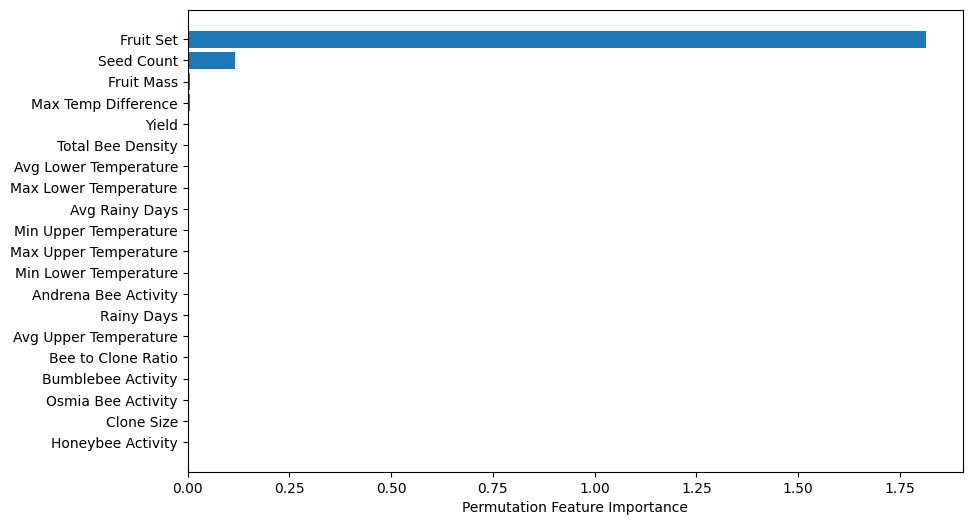

In [105]:
from sklearn.inspection import permutation_importance

# Assuming your stacking model is `stack_model`
perm_importance = permutation_importance(rf_model, X_test, y_test, n_repeats=10, random_state=42)
sorted_idx = perm_importance.importances_mean.argsort()

plt.figure(figsize=(10, 6))
plt.barh(train.columns[sorted_idx], perm_importance.importances_mean[sorted_idx])
plt.xlabel("Permutation Feature Importance")
plt.show()

In [106]:
ty_pred = rf_model.predict(test)

In [107]:
sub = pd.read_csv('sample_submission.csv')
sub['yield'] = ty_pred
sub.to_csv('Exam.csv', index=False)